
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Split Data by Token Patching

In [1]:
import tqdm, torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import modelHandlers, dataLoaders, patching, evaluation

## Model

In [2]:
model = modelHandlers.load_model(model_type="gpt2-medium", DEVICE="cuda", lr=0.0, weight_decay=0.01)

Loaded pretrained model gpt2-medium into HookedTransformer
setting no_grad on ['embed', 'pos_embed', 'unembed', 'b_in', 'b_out', 'b_K', 'b_Q', 'b_V', 'b_O']


## Data

In [3]:
(mem_prompts, mem_counts),(non_mem_prompts,non_mem_counts) = dataLoaders.load_pile_splits("acc/gpt2-medium", as_torch=True)
train_dl, test_dl = dataLoaders.train_test_batching(mem_prompts, non_mem_prompts, mem_batch=5, non_mem_batch=5, test_frac=0.0, set_twice=None)

from /home/jupyter/paraMem/data/pile_splits/acc/gpt2-medium loading ['mem.pt', 'non_mem.pt']...


## Generate Perturbed Changed Sets

In [4]:
def generate_perturbed_set(train_dl, n_batches:int=4, decode:bool=False, disable_tqdm:bool=True, mem_set:bool=False):
    """
    generate a dataset from memorized paragraphs and their minimal pertubations 
    """ 
    c_set, c_set_perturbed = [], []
    nll_metric_NI, em_metric_NI = [], []
    for batch_i, (c_toks_NI, k_toks_NI) in enumerate(tqdm.tqdm(train_dl, total=n_batches, disable=False)):
        
        if mem_set: ##perturb memorized set
            toks_NI = c_toks_NI.squeeze(0)
        else: ## perturb non-memorized set
            toks_NI = k_toks_NI.squeeze(0)
            
        pref_cont_split = int(toks_NI.shape[-1] / 2)
        pref_NI = toks_NI[:,:pref_cont_split].clone()
    
        pertubed_pref_NI = patching.get_random_tok(pref_NI, vocab_size= model.cfg.d_vocab, seed=-1)
        nll_metric, em_metric, most_changed_preds, interv_tok_pos = patching.token_patching_loop(model, toks_NI, pertubed_pref_NI, decode=decode, disable_tqdm=disable_tqdm)
        nll_metric_NI.append(nll_metric)
        em_metric_NI.append(em_metric)
        
        pref_NI[torch.arange(0,toks_NI.shape[0]),interv_tok_pos] = pertubed_pref_NI[torch.arange(0,toks_NI.shape[0]),interv_tok_pos] ## replace intervention token in prefix        
        c_set_perturbed.append(torch.cat([pref_NI, most_changed_preds], dim=-1).squeeze())
        c_set.append(c_toks_NI.squeeze(0))

        if batch_i+1 == n_batches:
            ## convert to tensor and reshape back to N x I shape
            c_set, c_set_perturbed = torch.stack(c_set), torch.stack(c_set_perturbed)
            c_set, c_set_perturbed = c_set.view(-1, c_set.shape[-1]), c_set_perturbed.view(-1, c_set_perturbed.shape[-1])
            nll_metric_NI, em_metric_NI = torch.stack(nll_metric_NI).view(-1, pref_cont_split), torch.stack(em_metric_NI).view(-1, pref_cont_split)
            return (c_set, c_set_perturbed), (nll_metric_NI, em_metric_NI)

(c_set, c_set_perturbed),(c_nll_metric_NI, c_em_metric_NI)  = generate_perturbed_set(train_dl, n_batches=2, decode=True, mem_set=True)
(k_set, k_set_perturbed),(k_nll_metric_NI, k_em_metric_NI)  = generate_perturbed_set(train_dl, n_batches=2, decode=True, mem_set=False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 50%|█████     | 1/2 [02:18<02:18, 138.66s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 50%|█████     | 1/2 [02:17<02:17, 138.00s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 50%|█████     | 1/2 [04:36<04:36, 276.19s/it]


### Avergae drop in EM per token

In [125]:
c_em_change = (torch.repeat_interleave(c_em_metric_NI[:,0].unsqueeze(-1), 49, dim=-1) - c_em_metric_NI[:,1:]).mean(-1).mean(0).item()
k_em_change = (torch.repeat_interleave(k_em_metric_NI[:,0].unsqueeze(-1), 49, dim=-1) - k_em_metric_NI[:,1:]).mean(-1).mean(0).item()

In [126]:
#torch.save(c_set, "/home/jupyter/paraMem/data/pile_splits/acc/gpt2-medium/mem_toks.pt")
#torch.save(c_set_perturbed, "/home/jupyter/paraMem/data/pile_splits/acc/gpt2-medium/perturbed_mem_toks.pt")

In [143]:
c_y = (torch.repeat_interleave(c_em_metric_NI[:,0].unsqueeze(-1), 50, dim=-1) - c_em_metric_NI[:,:]) 
k_y = (torch.repeat_interleave(k_em_metric_NI[:,0].unsqueeze(-1), 50, dim=-1) - k_em_metric_NI[:,:]) 

#c_y = (c_nll_metric_NI[:,1:] - torch.repeat_interleave(c_nll_metric_NI[:,0].unsqueeze(-1), 49, dim=-1)) 
#k_y = (k_nll_metric_NI[:,1:] torch.repeat_interleave(k_nll_metric_NI[:,0].unsqueeze(-1), 49, dim=-1)) 

#c_y = (c_y-c_y.min()) / (c_y.max()-c_y.min())
#k_y = (k_y-k_y.min()) / (k_y.max()-k_y.min())
#c_max, _ = c_y.max(-1)
#k_max, _ = k_y.max(-1)
#c_y = c_y / c_max
#k_y = k_y / k_max.max()

#c_y, k_y = c_y.mean(0), k_y.mean(0)

c_y = torch.cumsum(c_y.mean(0), dim=-1).numpy()
k_y = torch.cumsum(k_y.mean(0), dim=-1).numpy()
x = np.arange(0, c_y.shape[-1])

c_y = c_y / c_em_metric_NI[:,-1].mean()#50#abs(k_y[-1])
k_y = k_y / c_em_metric_NI[:,-1].mean() #50#abs(k_y[-1])

#c_y = c_y / c_y[-1]
#k_y = k_y / k_y[-1]

## Plot CumSum Plot

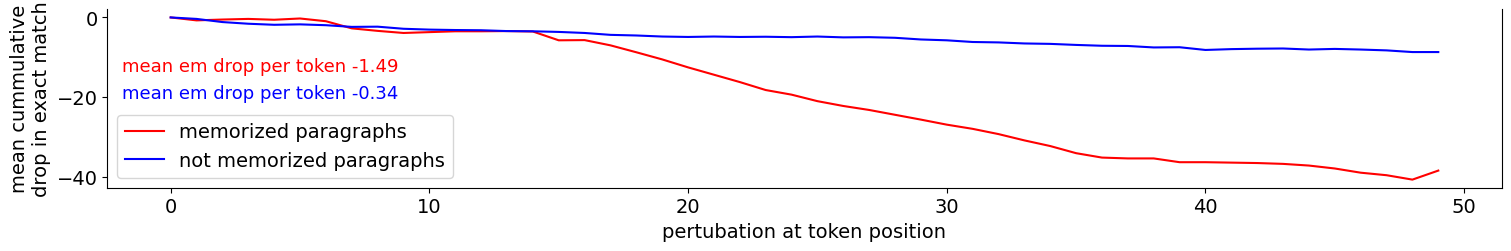

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(15, 2.4), layout='constrained')#, gridspec_kw={'hspace': 0.9}
fontsize = 14

c_label = ax.plot(x, c_y, c="red", label="memorized paragraphs")
k_label = ax.plot(x, k_y, c="blue", label="not memorized paragraphs")

ax.set_xlabel(r'pertubation at token position', fontsize=fontsize) #\searrow
ax.set_ylabel('mean cummulative\ndrop in exact match', fontsize=fontsize) #\searrow

#ax.set_title("Mean drop in exact match drop due to intervention on 50 different prefixes", loc='left') #minK, mean, 
ax.legend(loc='lower left', fontsize=fontsize) #minK, mean, 

ax.text(0.11, 0.68, f'mean em drop per token {c_em_change:.2f}', color="red", fontsize=fontsize-1, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.text(0.11, 0.53, f'mean em drop per token {k_em_change:.2f}', color="blue", fontsize=fontsize-1, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

#ax[1].set_xticks(x)
#labels = ax[1].set_xticklabels(xlabels, fontsize=fontsize-2, rotation=90)
fig.savefig(f"{ROOT}/results/em_drop.pdf", dpi=200, bbox_inches="tight")